In [45]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

In [46]:
DATASET_PATH = "./Dataset/Logos/"
INP_SHAPE = (100,100)

images = []

In [47]:
for filename in os.listdir(DATASET_PATH):
    img = tf.keras.utils.load_img(os.path.join(DATASET_PATH, filename), target_size = INP_SHAPE)
    img = tf.keras.utils.img_to_array(img)
    images.append(img)

In [48]:
images = np.asarray(images).astype(np.float32) / 255

In [49]:
x_train = images[:-10]
x_test = images[-10:]

In [50]:
BATCH_SIZE = 50
EPOCHS = 25
LEARNING_RATE = 1e-4

IMG_ORIGINAL_SIZE = x_train[0].shape
IMG_SHAPE = IMG_ORIGINAL_SIZE[0]*IMG_ORIGINAL_SIZE[1]*IMG_ORIGINAL_SIZE[2]

HIDDEN_DIM = 512
LATENT_DIM = 32

In [51]:
class VAE(tf.keras.Model):
    def __init__(self, dim, **kwargs):
        super(VAE, self).__init__(**kwargs)
        
        h_dim = dim[0]
        z_dim = dim[1]
        
        self.fc1 = tf.keras.layers.Dense(h_dim, activation='relu')
        self.fc2 = tf.keras.layers.Dense(z_dim)
        self.fc3 = tf.keras.layers.Dense(z_dim)
        
        self.fc4 = tf.keras.layers.Dense(h_dim)
        self.fc5 = tf.keras.layers.Dense(IMG_SHAPE)
        
        self.encode_batch_norm = tf.keras.layers.BatchNormalization()
        self.decode_batch_norm = tf.keras.layers.BatchNormalization()
        
    def encode(self, x):
        h = self.encode_batch_norm(x)
        h = self.fc1(h)
        return self.fc2(h), self.fc3(h)
    
    def decode_logits(self, x):
        h = self.fc4(x)
        h = self.fc5(h)
        return self.decode_batch_norm(h)
    
    def decode(self, x):
        return tf.nn.sigmoid(self.decode_logits(x))
    
    def reparameterize(self, mu, sigma):
        std = np.exp(sigma * 0.5)
        eps = tf.random.normal(std.shape)
        return mu + eps*std
    
    def call(self, x):
        mu, sigma = self.encode(x)
        recon_logit = self.reparameterize(mu, sigma)
        recon_logit = self.decode(recon_logit)
        
        return recon_logit, mu, sigma

In [52]:
model = VAE([HIDDEN_DIM, LATENT_DIM])
model.build(input_shape = (BATCH_SIZE, IMG_SHAPE))
model.summary()

d:\Apps\Conda\envs\TensorFlow\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'vae_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "vae_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [53]:
dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.shuffle(BATCH_SIZE*5).batch(BATCH_SIZE)\

optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE)

In [54]:
loss_hist = []
kl_div_hist = []

for e in range(EPOCHS):
    for x in dataset:
        x = tf.reshape(x, (-1, IMG_SHAPE))
        with tf.GradientTape() as tape:
            recon_logit, mu, sigma = model(x)
            
            recon_loss = tf.nn.sigmoid_cross_entropy_with_logits(x, recon_logit)
            recon_loss = tf.reduce_sum(recon_loss) / BATCH_SIZE
            
            kl_div = -0.5 * tf.reduce_sum(1.0 + sigma - tf.square(mu) - tf.exp(sigma), axis=1)
            kl_div = tf.reduce_mean(kl_div)
            
            loss = tf.reduce_mean(kl_div + recon_loss)
            
        
        gradient = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradient, model.trainable_variables))
        
        loss_hist.append(loss)
        kl_div_hist.append(kl_div)
    
    print(f"Epoch #{e+1}/{EPOCHS} | Recon Loss = {recon_loss} | Kl Div = {kl_div} | Loss = {loss}")
            

Epoch #1/25 | Recon Loss = 20141.6953125 | Kl Div = 64.15807342529297 | Loss = 20205.853515625
Epoch #2/25 | Recon Loss = 17858.775390625 | Kl Div = 728.2662963867188 | Loss = 18587.041015625
Epoch #3/25 | Recon Loss = 17048.17578125 | Kl Div = 1091.285400390625 | Loss = 18139.4609375
Epoch #4/25 | Recon Loss = 16033.103515625 | Kl Div = 690.9285888671875 | Loss = 16724.03125
Epoch #5/25 | Recon Loss = 16245.5185546875 | Kl Div = 554.4512939453125 | Loss = 16799.970703125
Epoch #6/25 | Recon Loss = 16055.0888671875 | Kl Div = 397.3149108886719 | Loss = 16452.404296875
Epoch #7/25 | Recon Loss = 14804.01953125 | Kl Div = 338.36016845703125 | Loss = 15142.3798828125
Epoch #8/25 | Recon Loss = 15296.81640625 | Kl Div = 267.4659729003906 | Loss = 15564.2822265625
Epoch #9/25 | Recon Loss = 15863.8466796875 | Kl Div = 229.9988250732422 | Loss = 16093.845703125
Epoch #10/25 | Recon Loss = 15218.0546875 | Kl Div = 202.2964324951172 | Loss = 15420.3515625
Epoch #11/25 | Recon Loss = 15639.0507

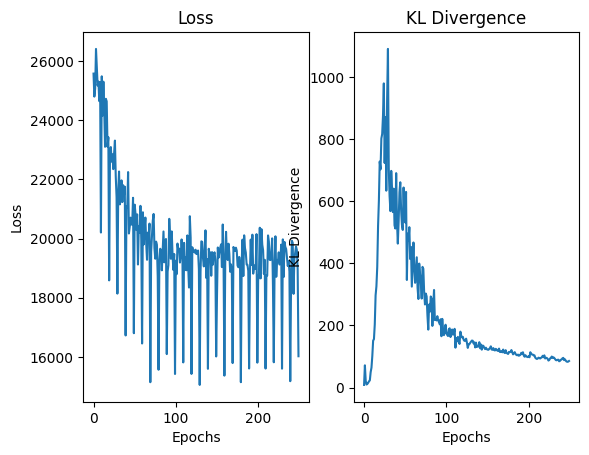

In [55]:
plt.subplot(1, 2, 1)
plt.plot(loss_hist)
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(kl_div_hist)
plt.title("KL Divergence")
plt.xlabel("Epochs")
plt.ylabel("KL Divergence")

plt.show()

In [56]:
def get_img(x):
    out = model.decode(x)
    out = tf.reshape(out, (-1, IMG_ORIGINAL_SIZE[0], IMG_ORIGINAL_SIZE[1], IMG_ORIGINAL_SIZE[2]))
    return out

In [57]:
mu, sigma = model.encode(x_test.reshape(-1, IMG_SHAPE))
x = model.reparameterize(mu, sigma)
recon_img = get_img(x)

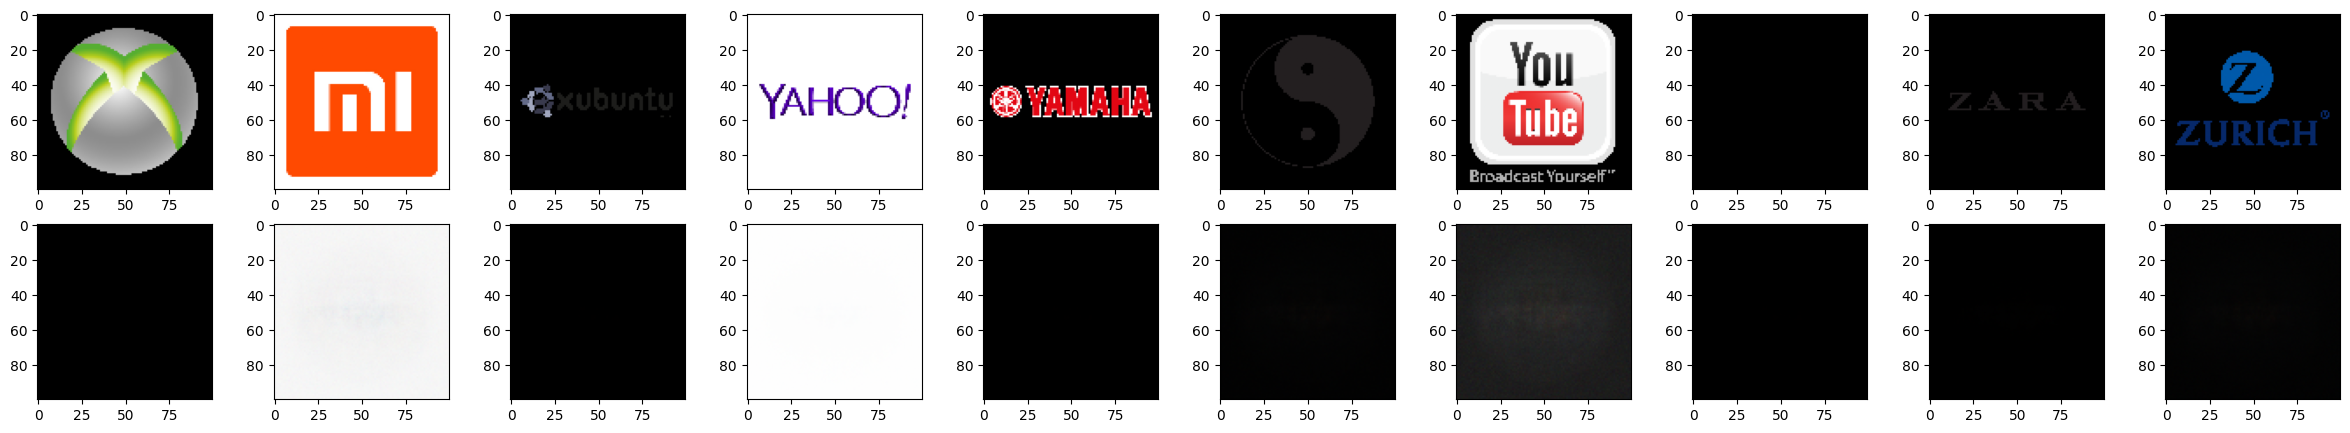

In [58]:
fig, ax = plt.subplots(nrows = 2, ncols = len(x_test), figsize = (30,5))

for i in range(len(x_test)):
    ax[0, i].imshow(x_test[i])
    
    ax[1, i].imshow(recon_img[i])